In [1]:
from itertools import islice, cycle
import numpy as np
import numpy.typing as npt
import pandas as pd
import typing as t
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as ac
import pandas as pd
import pickle

from scipy.optimize import minimize, least_squares, basinhopping


def get_vibrant_colors(n_colors: int, ordered: bool = False) -> t.List[str]:
    if ordered:
        vibrant_color_list = [
            "#0077BB",
            "#33BBEE",
            "#44EE66",
            "#229933",
            "#FFBB00",  # FFCC11
            "#EE7733",
            "#CC3311",
            "#EE3377",
            "#BB33BB",
            "#8833EE",
        ]
    else:
        vibrant_color_list = [
            "#EE7733",
            "#0077BB",
            "#CC3311",
            "#33BBEE",
            "#229933",
            "#EE3377",
            "#44EE66",
            "#BB33BB",
            "#FFBB00",  # FFCC11
            "#8833EE",
        ]
    if n_colors > len(vibrant_color_list):
        return list(islice(cycle(vibrant_color_list), n_colors))
    else:
        colors_list_idx = np.linspace(
            0, len(vibrant_color_list) - 1, n_colors, dtype=int
        ).tolist()
        return list([vibrant_color_list[idx] for idx in colors_list_idx])

# Fitting Collisional Data

In [2]:
def aggregate_states(states_file: str, agg_col_nums: t.List[int], temperature_profile: u.Quantity):
    if agg_col_nums is None:
        # Assuming diatomic by default.
        agg_col_nums = [9, 10]

    agg_col_names = ["agg" + str(idx + 1) for idx in range(0, len(agg_col_nums))]

    states = pd.read_csv(
        states_file,
        sep=r"\s+",
        names=["id", "energy", "g", "tau"] + agg_col_names,
        usecols=[0, 1, 2, 5] + agg_col_nums,
    )
    agg_states = states.groupby(by=agg_col_names, as_index=False).agg(energy_agg=("energy", "min"))
    n_agg_states = len(agg_states)

    agg_states = agg_states.sort_values(by="energy_agg")
    agg_states["id_agg"] = np.arange(0, n_agg_states, dtype=int)
    states = states.merge(
        agg_states[["id_agg", "energy_agg"] + agg_col_names],
        on=agg_col_names,
        how="left",
    )

    pop_grid = np.zeros((temperature_profile.shape[0], n_agg_states))
    ac_h_c_on_kB = ac.h * ac.c.cgs / ac.k_B
    for layer_idx, layer_temperature in enumerate(temperature_profile):
        states["q_lev"] = states["g"] * np.exp(
            -ac_h_c_on_kB * (states["energy"] << 1 / u.cm) / layer_temperature
        )
        states["n"] = states["q_lev"] / states["q_lev"].sum()
        states_agg_n = states.groupby(by=["id_agg"], as_index=False).agg(n_agg=("n", "sum"))
        pop_grid[layer_idx] = states_agg_n.sort_values(by="id_agg")["n_agg"]

    states = states[["id", "energy", "g", "tau", "id_agg"] + agg_col_names]

    return agg_states, states, pop_grid


mol_num_dens_dict = {
    "O": [1.40647299e+20, 1.14986117e+20, 9.40100015e+19, 7.68630333e+19, 6.28457571e+19, 5.13865625e+19,
          4.20183035e+19, 3.43591954e+19, 2.80972083e+19, 2.29773141e+19, 1.87910674e+19, 1.53680914e+19,
          1.25691213e+19, 1.02803192e+19, 8.40862914e+18, 6.87798020e+18, 5.62618470e+18, 4.60240268e+18,
          3.76506979e+18, 3.08020390e+18, 2.52002098e+18, 2.06180381e+18, 1.68697737e+18, 1.38035299e+18,
          1.12951057e+18, 9.24293582e+17, 7.56396196e+17, 6.19025821e+17, 5.06627195e+17, 4.14656825e+17,
          3.39398571e+17, 2.77812872e+17, 2.27413469e+17, 1.86166601e+17, 1.52408587e+17, 1.24778425e+17,
          1.02162682e+17, 8.36504205e+16, 6.84963399e+16, 5.60906335e+16, 4.59343338e+16, 3.76191483e+16,
          3.08109669e+16, 2.52363713e+16, 2.06715998e+16, 1.69335208e+16, 1.38722481e+16, 1.13650998e+16,
          9.31165561e+15, 7.62971371e+15, 6.25198190e+15, 5.12337060e+15, 4.19877780e+15, 3.44127639e+15,
          2.82063085e+15, 2.31208337e+15, 1.89536034e+15, 1.55385925e+15, 1.27398321e+15, 1.04459617e+15,
          8.56577039e+14, 7.02454647e+14, 5.76108947e+14, 4.72526361e+14, 3.87599487e+14, 3.17963109e+14,
          2.60859909e+14, 2.14030517e+14, 1.75623462e+14, 1.44121434e+14, 1.18280889e+14, 9.70825830e+13,
          7.96910608e+13, 6.54214640e+13, 5.37123463e+13, 4.41034010e+13, 3.62172132e+13, 2.97443102e+13,
          2.44309106e+13, 2.00688867e+13, 1.64875376e+13, 1.35468482e+13, 1.11319633e+13, 9.14865876e+12,
          7.51962901e+12, 6.18144381e+12, 5.08205316e+12, 4.17874179e+12, 3.43645176e+12, 2.82640720e+12,
          2.32498630e+12, 1.91279634e+12, 1.57391498e+12, 1.29526789e+12, 1.06611823e+12, 8.77647850e+11,
          7.22613634e+11, 5.95065527e+11, 4.90115159e+11, 4.03745953e+11] << u.cm ** -3,
    "O2": [2.81294598e+20, 2.29972234e+20, 1.88020003e+20, 1.53726067e+20, 1.25691514e+20, 1.02773125e+20,
           8.40366069e+19, 6.87183909e+19, 5.61944166e+19, 4.59546282e+19, 3.75821347e+19, 3.07361828e+19,
           2.51382425e+19, 2.05606385e+19, 1.68172583e+19, 1.37559604e+19, 1.12523694e+19, 9.20480535e+18,
           7.53013958e+18, 6.16040781e+18, 5.04004196e+18, 4.12360762e+18, 3.37395474e+18, 2.76070597e+18,
           2.25902114e+18, 1.84858716e+18, 1.51279239e+18, 1.23805164e+18, 1.01325439e+18, 8.29313650e+17,
           6.78797141e+17, 5.55625744e+17, 4.54826938e+17, 3.72333202e+17, 3.04817173e+17, 2.49556850e+17,
           2.04325364e+17, 1.67300841e+17, 1.36992680e+17, 1.12181267e+17, 9.18686676e+16, 7.52382966e+16,
           6.16219338e+16, 5.04727425e+16, 4.13431995e+16, 3.38670416e+16, 2.77444963e+16, 2.27301996e+16,
           1.86233112e+16, 1.52594274e+16, 1.25039638e+16, 1.02467412e+16, 8.39755560e+15, 6.88255278e+15,
           5.64126170e+15, 4.62416674e+15, 3.79072067e+15, 3.10771850e+15, 2.54796643e+15, 2.08919235e+15,
           1.71315408e+15, 1.40490929e+15, 1.15221789e+15, 9.45052722e+14, 7.75198975e+14, 6.35926218e+14,
           5.21719818e+14, 4.28061034e+14, 3.51246925e+14, 2.88242869e+14, 2.36561778e+14, 1.94165166e+14,
           1.59382122e+14, 1.30842928e+14, 1.07424693e+14, 8.82068019e+13, 7.24344264e+13, 5.94886204e+13,
           4.88618213e+13, 4.01377734e+13, 3.29750752e+13, 2.70936964e+13, 2.22639266e+13, 1.82973175e+13,
           1.50392580e+13, 1.23628876e+13, 1.01641063e+13, 8.35748357e+12, 6.87290352e+12, 5.65281439e+12,
           4.64997259e+12, 3.82559269e+12, 3.14782997e+12, 2.59053578e+12, 2.13223646e+12, 1.75529570e+12,
           1.44522727e+12, 1.19013105e+12, 9.80230318e+11, 8.07491905e+11] << u.cm ** -3,
    "O3": [2.81294598e+20, 2.29972234e+20, 1.88020003e+20, 1.53726067e+20, 1.25691514e+20, 1.02773125e+20,
           8.40366069e+19, 6.87183909e+19, 5.61944166e+19, 4.59546282e+19, 3.75821347e+19, 3.07361828e+19,
           2.51382425e+19, 2.05606385e+19, 1.68172583e+19, 1.37559604e+19, 1.12523694e+19, 9.20480535e+18,
           7.53013958e+18, 6.16040781e+18, 5.04004196e+18, 4.12360762e+18, 3.37395474e+18, 2.76070597e+18,
           2.25902114e+18, 1.84858716e+18, 1.51279239e+18, 1.23805164e+18, 1.01325439e+18, 8.29313650e+17,
           6.78797141e+17, 5.55625744e+17, 4.54826938e+17, 3.72333202e+17, 3.04817173e+17, 2.49556850e+17,
           2.04325364e+17, 1.67300841e+17, 1.36992680e+17, 1.12181267e+17, 9.18686676e+16, 7.52382966e+16,
           6.16219338e+16, 5.04727425e+16, 4.13431995e+16, 3.38670416e+16, 2.77444963e+16, 2.27301996e+16,
           1.86233112e+16, 1.52594274e+16, 1.25039638e+16, 1.02467412e+16, 8.39755560e+15, 6.88255278e+15,
           5.64126170e+15, 4.62416674e+15, 3.79072067e+15, 3.10771850e+15, 2.54796643e+15, 2.08919235e+15,
           1.71315408e+15, 1.40490929e+15, 1.15221789e+15, 9.45052722e+14, 7.75198975e+14, 6.35926218e+14,
           5.21719818e+14, 4.28061034e+14, 3.51246925e+14, 2.88242869e+14, 2.36561778e+14, 1.94165166e+14,
           1.59382122e+14, 1.30842928e+14, 1.07424693e+14, 8.82068019e+13, 7.24344264e+13, 5.94886204e+13,
           4.88618213e+13, 4.01377734e+13, 3.29750752e+13, 2.70936964e+13, 2.22639266e+13, 1.82973175e+13,
           1.50392580e+13, 1.23628876e+13, 1.01641063e+13, 8.35748357e+12, 6.87290352e+12, 5.65281439e+12,
           4.64997259e+12, 3.82559269e+12, 3.14782997e+12, 2.59053578e+12, 2.13223646e+12, 1.75529570e+12,
           1.44522727e+12, 1.19013105e+12, 9.80230318e+11, 8.07491905e+11] << u.cm ** -3,
}


def add_col_chem_rates(
        agg_states: pd.DataFrame, pop_grid: npt.NDArray[np.float64], y_matrix: npt.NDArray[np.float64], layer_idx: int,
        layer_temp: float
) -> npt.NDArray[np.float64]:
    def add_col_chem_rate(
            estate_u: str,
            v_u: int,
            estate_l: str,
            v_l: int,
            rate: float,
            mol_depend: str,
    ):
        upper_id = agg_states.loc[
            (agg_states["agg1"] == estate_u) & (agg_states["agg2"] == v_u),
            "id_agg",
        ].values[0]
        lower_id = agg_states.loc[
            (agg_states["agg1"] == estate_l) & (agg_states["agg2"] == v_l),
            "id_agg",
        ].values[0]
        # print(f"Upper = {upper_id}, type ={type(upper_id)}")
        # print(f"Lower = {lower_id}, type ={type(lower_id)}")
        depend_num_dens = mol_num_dens_dict.get(mol_depend)[layer_idx]
        # print(f"{mol_depend} number density = {depend_num_dens}")
        c_fi = (rate * u.cm ** 3 / u.s) * depend_num_dens
        c_if = c_fi * (pop_grid[layer_idx, upper_id] / pop_grid[layer_idx, lower_id])
        print(f"({upper_id}, {lower_id}): C_fi = {c_fi}, C_if = {c_if}.")

        if lower_id == upper_id:
            # Formation/destruction:
            y_matrix[upper_id, upper_id] += c_fi
        else:
            y_matrix[upper_id, lower_id] += c_if
            y_matrix[lower_id, upper_id] += c_fi
            y_matrix[upper_id, upper_id] -= c_fi
            y_matrix[lower_id, lower_id] -= c_if

    # print("Initial Y matrix = ", y_matrix)
    # P. H. Paul (10.1021/j100021a004)
    # OH(A, v'') + O_2 -> OH(X, v'') + O_2
    add_col_chem_rate("A2Sigma+", 0, "X2Pi", 0, 13.4e-11, "O2")  # @ 1900 K, 15.6 @ 2300 K
    add_col_chem_rate("A2Sigma+", 1, "X2Pi", 0, 15.1e-11, "O2")  # @ 1900 K, 16.8 @ 2300 K
    add_col_chem_rate("A2Sigma+", 1, "A2Sigma+", 0, 1.68e-11, "O2")  # @ 1900 K, 1.74 @ 2300 K

    # add_col_chem_rate("A2Sigma+", 1, "A2Sigma+", 0, 3.0e-11, "O2")  # @ 1900 K, 1.74 @ 2300 K

    # Adler-Golden (10.1029/97JA01622)
    # OH(X, v'') + O_2 -> OH(X, v'') + O_2
    p_v_list = [0.043, 0.083, 0.15, 0.23, 0.36, 0.50, 0.72, 0.75, 0.95, 1.00725]
    c_val = 0.723 * 4.4e-12
    for v_val in range(1, len(p_v_list) + 1):
        print("v=", v_val)
        v_tot = 0
        for dv_val in range(1, v_val + 1):
            print("dv=", dv_val)
            add_col_chem_rate(
                "X2Pi",
                v_val,
                "X2Pi",
                v_val - dv_val,
                c_val * p_v_list[v_val - 1] ** dv_val,
                "O2",
            )
            v_tot += c_val * p_v_list[v_val - 1] ** dv_val
        print(f"v_tot(v={v_val}) = {v_tot}")

    # Varandas (0.1016/j.cplett.2004.08.023)
    # Destruction by O + OH -> O_2 + H
    add_col_chem_rate("X2Pi", 0, "X2Pi", 0, -26.45e-12, "O")  # @ 255 K, 33.62 @ 210 K
    add_col_chem_rate("X2Pi", 1, "X2Pi", 1, -23.59e-12, "O")  # @ 255 K, 27.20 @ 210 K
    add_col_chem_rate("X2Pi", 2, "X2Pi", 2, -24.36e-12, "O")  # @ 255 K, 29.09 @ 210 K
    add_col_chem_rate("X2Pi", 3, "X2Pi", 3, -29.31e-12, "O")  # @ 255 K, 32.16 @ 210 K
    add_col_chem_rate("X2Pi", 4, "X2Pi", 4, -34.49e-12, "O")  # @ 255 K, 33.83 @ 210 K
    add_col_chem_rate("X2Pi", 5, "X2Pi", 5, -30.95e-12, "O")  # @ 255 K, 32.99 @ 210 K
    add_col_chem_rate("X2Pi", 6, "X2Pi", 6, -32.81e-12, "O")  # @ 255 K, 35.09 @ 210 K
    add_col_chem_rate("X2Pi", 7, "X2Pi", 7, -38.76e-12, "O")  # @ 255 K, 42.18 @ 210 K
    add_col_chem_rate("X2Pi", 8, "X2Pi", 8, -41.85e-12, "O")  # @ 255 K, 42.71 @ 210 K
    add_col_chem_rate("X2Pi", 9, "X2Pi", 9, -47.78e-12, "O")  # @ 255 K, 50.69 @ 210 K

    # P. J. S. B. Caridade et al. (10.5194/acp-13-1-2013)
    # O + OH(v') -> OH(v'') + O ALL @ 300 K.
    add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 19.2e-12, "O")
    add_col_chem_rate("X2Pi", 2, "X2Pi", 0, 14.2e-12, "O")
    add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 10.5e-12, "O")
    add_col_chem_rate("X2Pi", 3, "X2Pi", 0, 9.4e-12, "O")
    add_col_chem_rate("X2Pi", 3, "X2Pi", 1, 9.6e-12, "O")
    add_col_chem_rate("X2Pi", 3, "X2Pi", 2, 8.1e-12, "O")
    add_col_chem_rate("X2Pi", 4, "X2Pi", 0, 6.4e-12, "O")
    add_col_chem_rate("X2Pi", 4, "X2Pi", 1, 7.8e-12, "O")
    add_col_chem_rate("X2Pi", 4, "X2Pi", 2, 6.9e-12, "O")
    add_col_chem_rate("X2Pi", 4, "X2Pi", 3, 4.8e-12, "O")
    add_col_chem_rate("X2Pi", 5, "X2Pi", 0, 6.3e-12, "O")
    add_col_chem_rate("X2Pi", 5, "X2Pi", 1, 4.7e-12, "O")
    add_col_chem_rate("X2Pi", 5, "X2Pi", 2, 6.0e-12, "O")
    add_col_chem_rate("X2Pi", 5, "X2Pi", 3, 3.8e-12, "O")
    add_col_chem_rate("X2Pi", 5, "X2Pi", 4, 3.8e-12, "O")
    add_col_chem_rate("X2Pi", 6, "X2Pi", 0, 4.6e-12, "O")
    add_col_chem_rate("X2Pi", 6, "X2Pi", 1, 4.4e-12, "O")
    add_col_chem_rate("X2Pi", 6, "X2Pi", 2, 5.0e-12, "O")
    add_col_chem_rate("X2Pi", 6, "X2Pi", 3, 4.7e-12, "O")
    add_col_chem_rate("X2Pi", 6, "X2Pi", 4, 4.1e-12, "O")
    add_col_chem_rate("X2Pi", 6, "X2Pi", 5, 4.5e-12, "O")
    add_col_chem_rate("X2Pi", 7, "X2Pi", 0, 3.4e-12, "O")
    add_col_chem_rate("X2Pi", 7, "X2Pi", 1, 3.1e-12, "O")
    add_col_chem_rate("X2Pi", 7, "X2Pi", 2, 3.6e-12, "O")
    add_col_chem_rate("X2Pi", 7, "X2Pi", 3, 3.3e-12, "O")
    add_col_chem_rate("X2Pi", 7, "X2Pi", 4, 3.5e-12, "O")
    add_col_chem_rate("X2Pi", 7, "X2Pi", 5, 3.1e-12, "O")
    add_col_chem_rate("X2Pi", 7, "X2Pi", 6, 4.0e-12, "O")
    add_col_chem_rate("X2Pi", 8, "X2Pi", 0, 2.4e-12, "O")
    add_col_chem_rate("X2Pi", 8, "X2Pi", 1, 2.3e-12, "O")
    add_col_chem_rate("X2Pi", 8, "X2Pi", 2, 2.4e-12, "O")
    add_col_chem_rate("X2Pi", 8, "X2Pi", 3, 2.4e-12, "O")
    add_col_chem_rate("X2Pi", 8, "X2Pi", 4, 2.1e-12, "O")
    add_col_chem_rate("X2Pi", 8, "X2Pi", 5, 2.7e-12, "O")
    add_col_chem_rate("X2Pi", 8, "X2Pi", 6, 3.0e-12, "O")
    add_col_chem_rate("X2Pi", 8, "X2Pi", 7, 4.2e-12, "O")
    add_col_chem_rate("X2Pi", 9, "X2Pi", 0, 1.2e-12, "O")
    add_col_chem_rate("X2Pi", 9, "X2Pi", 1, 1.3e-12, "O")
    add_col_chem_rate("X2Pi", 9, "X2Pi", 2, 2.1e-12, "O")
    add_col_chem_rate("X2Pi", 9, "X2Pi", 3, 1.8e-12, "O")
    add_col_chem_rate("X2Pi", 9, "X2Pi", 4, 2.0e-12, "O")
    add_col_chem_rate("X2Pi", 9, "X2Pi", 5, 1.7e-12, "O")
    add_col_chem_rate("X2Pi", 9, "X2Pi", 6, 1.8e-12, "O")
    add_col_chem_rate("X2Pi", 9, "X2Pi", 7, 2.1e-12, "O")
    add_col_chem_rate("X2Pi", 9, "X2Pi", 8, 3.3e-12, "O")

    ozone_formation_distribution = np.array([4, 0.5, 0.5, 1, 1, 2, 4, 19, 28, 38, 2])
    # percentage distribution of total production going to each v=idx.
    total_rate = 1.4e-10 * np.exp(-470 / layer_temp.value)
    for v_val in range(len(ozone_formation_distribution)):
        v_rate = total_rate * ozone_formation_distribution[v_val] / 100
        add_col_chem_rate("X2Pi", v_val, "X2Pi", v_val, v_rate, "O3")
    return y_matrix

In [3]:
nlayers = 100
temperature_profile = np.linspace(1750, 750, nlayers) << u.K
agg_states, states, pop_grid = aggregate_states(states_file=r"/mnt/c/PhD/OH/ExoMol/16O-1H__MYTHOS.noB4.states",
                                                agg_col_nums=[9, 10], temperature_profile=temperature_profile)
y_matrix = np.zeros((len(agg_states), len(agg_states))) << (1 / u.s)
agg_states

,agg1,agg2,energy_agg,id_agg
106,X2Pi,0,0.000000,0
107,X2Pi,1,3568.471362,1
108,X2Pi,2,6971.345730,2
109,X2Pi,3,10210.544951,3
110,X2Pi,4,13287.164225,4
...,...,...,...,...
101,C2Sigma+,75,129637.623490,127
102,C2Sigma+,76,130186.174270,128
103,C2Sigma+,77,130742.619260,129
104,C2Sigma+,78,131306.887070,130


In [41]:
layer_idx = 80
y_matrix = add_col_chem_rates(agg_states=agg_states, pop_grid=pop_grid, y_matrix=y_matrix, layer_idx=layer_idx,
                              layer_temp=temperature_profile[layer_idx])

(13, 0): C_fi = 4418.6600768 1 / s, C_if = 7.685270370299363e-19 1 / s.
(17, 0): C_fi = 4979.2363552 1 / s, C_if = 9.486663413661622e-21 1 / s.
(17, 13): C_fi = 553.98126336 1 / s, C_if = 6.068442885165448 1 / s.
v= 1
dv= 1
(1, 0): C_fi = 4.510713296728319 1 / s, C_if = 0.020102263340093147 1 / s.
v_tot(v=1) = 1.3679159999999998e-13
v= 2
dv= 1
(2, 1): C_fi = 8.706725665777919 1 / s, C_if = 0.050025356537968156 1 / s.
dv= 2
(2, 0): C_fi = 0.7226582302595674 1 / s, C_if = 1.850410222206481e-05 1 / s.
v_tot(v=2) = 2.8595488679999997e-13
v= 3
dv= 1
(3, 2): C_fi = 15.735046383936 1 / s, C_if = 0.11624355789169882 1 / s.
dv= 2
(3, 1): C_fi = 2.3602569575904 1 / s, C_if = 0.00010018333502163835 1 / s.
dv= 3
(3, 0): C_fi = 0.3540385436385599 1 / s, C_if = 6.697095283204323e-08 1 / s.
v_tot(v=3) = 5.5949355e-13
v= 4
dv= 1
(4, 3): C_fi = 24.1270711220352 1 / s, C_if = 0.22886705258538823 1 / s.
dv= 2
(4, 2): C_fi = 5.549226358068096 1 / s, C_if = 0.00038887675068379135 1 / s.
dv= 3
(4, 1): C_fi 

In [ ]:
quenching_total = [0.013, 0.0265, 0.052, 0.088, 0.17, 0.3, 0.7, 0.8, 1.7, 1.5, 2.79]
fit_extra = [3.21515904, 3.83866479, 4.39559635, 4.82923495, 5.08618411, 5.79519431, 5.92829026, 6.22476161, 6.2462764,
             6.59709307, 7.0635486, 7.63462636, 7.79270072, 8.60716109]
quenching_total += fit_extra
print(quenching_total)
p_v_list = [0.043, 0.083, 0.15, 0.23, 0.36, 0.50, 0.72, 0.75, 0.95, 0.8, 0.97]
p_v_list += [1.0 for _ in range(len(fit_extra))]
print(p_v_list)


def fit_rates(inputs):
    c_const = inputs[0]
    fit_p_v_list = inputs[1:]
    v_list = np.arange(1, len(quenching_total) + 1)
    error = 0
    for v_val in v_list:
        if v_val <= 9:
            rates = c_const * np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])
            # print(f"v'={v_val}, rates = {rates}. P_v = {p_v_list[v_val - 1]}, Sum(k)={sum(rates)}")
        else:
            rates = c_const * np.array([fit_p_v_list[v_val - 10] ** delta_v for delta_v in np.arange(1, v_val + 1)])
            # print(f"v'={v_val}, rates = {rates}. P_v = {fit_p_v_list[v_val - 10]}, Sum(k)={sum(rates)}")
        error += (sum(rates) - quenching_total[v_val - 1]) ** 2
    return error


x0 = [0.31812] + p_v_list[9:]
bounds = [(0.3181, 0.31814), ] + [(0.8, 1.5) for _ in range(len(p_v_list[9:]))]
print(bounds)

res = minimize(fit_rates, x0, bounds=bounds)
print(res)


def test_rates(v_val, c_const, p_v_list):
    p_v_delta_v_list = np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])
    return c_const * p_v_delta_v_list


new_p_v_list = np.concatenate((p_v_list[:9], res.x[1:]))

for v_val in range(1, len(quenching_total) + 1):
    test_rate = test_rates(v_val, res.x[0], new_p_v_list)
    print(f"v'={v_val}, Sum(k(v'')) = {sum(test_rate)}. Target Sum(k(v'')) = {quenching_total[v_val - 1]}")

print(f"C const. = {res.x[0]} (initial = {x0[0]})")
print(f"P_v values = {res.x[1:]} (initial = {p_v_list[9:]})")

In [ ]:
p_v_list = [0.043, 0.083, 0.15, 0.23, 0.36, 0.50, 0.72, 0.75, 0.95, 0.85714519, 0.96173984, 0.97328653, 0.98930833,
            0.99825627, 1.00150189, 0.9999211, 1.00764132, 1.0036461, 1.00293998, 0.99824835, 0.99886182, 1.00080735,
            1.00353255, 1.00163807, 1.00603109]
v_vals = np.arange(1, len(p_v_list) + 1)
poly_coefs = np.polyfit(v_vals, p_v_list, deg=3)
fit_v_vals = np.arange(len(p_v_list) + 1, 26)

known_v_fit = [sum([poly_coefs[idx] * v_val ** (len(poly_coefs) - idx - 1) for idx in range(len(poly_coefs))]) for v_val
               in v_vals]
extrapolate_v_fit = [sum([poly_coefs[idx] * fit_v_val ** (len(poly_coefs) - idx - 1) for idx in range(len(poly_coefs))])
                     for fit_v_val in fit_v_vals]

plt.scatter(np.arange(1, len(p_v_list) + 1), p_v_list, marker="D", color="#FF00FF")
plt.plot(v_vals, known_v_fit, linestyle="--", color="#00FFFF")
plt.plot(fit_v_vals, extrapolate_v_fit, color="#00FF00")

for fit_v_val in fit_v_vals:
    print(
        f"P_v(v={fit_v_val}) = {sum([poly_coefs[idx] * fit_v_val ** (len(poly_coefs) - idx - 1) for idx in range(len(poly_coefs))])}")
    plt.tight_layout()
plt.show()

In [ ]:
ac_h_c_on_k_B = ac.h * ac.c.cgs / ac.k_B
energy_vals = []
num_fixed = 11
for v_val in np.arange(1, len(quenching_total[:num_fixed]) + 1):
    v_energy = agg_states.loc[(agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"].values[0]
    energy_vals.append(v_energy)

poly_coefs = np.polyfit(energy_vals, quenching_total[:num_fixed], deg=3)
known_v_fit = [sum([poly_coefs[idx] * energy_val ** (len(poly_coefs) - idx - 1) for idx in range(len(poly_coefs))]) for
               energy_val in energy_vals]

fit_energy_vals = agg_states.loc[
    (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] >= num_fixed), "energy_agg"].to_numpy()
extrapolate_fit = [
    sum([poly_coefs[idx] * fit_energy_val ** (len(poly_coefs) - idx - 1) for idx in range(len(poly_coefs))]) for
    fit_energy_val in fit_energy_vals]

print(np.array(extrapolate_fit[1:]))

plt.scatter(energy_vals, quenching_total[:num_fixed], marker="D", color="#FF00FF")
plt.plot(energy_vals, known_v_fit, linestyle="--", color="#00FF00")
# plt.plot(fit_energy_vals, extrapolate_fit, linestyle="-.", color="#FF0000")
plt.scatter(fit_energy_vals, extrapolate_fit, marker="P", facecolor="none", edgecolor="#FF0000")
# plt.yscale("log")
plt.show()

  message: ABNORMAL: 
  success: False
   status: 2
      fun: 0.33361214925464533
        x: [ 1.166e+00  9.764e-05  3.125e+00  1.340e+00  1.691e-01
             0.000e+00]
      nit: 2
      jac: [-2.379e-05  1.748e+01 -1.151e-03  8.235e-05 -6.113e-03
             5.541e-02]
     nfev: 322
     njev: 46
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
Fit RMS = 0.33361214925464533


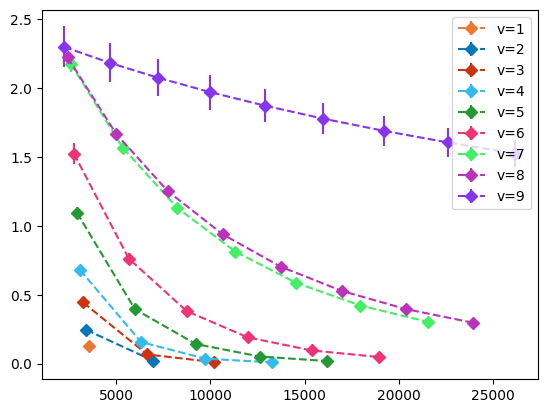

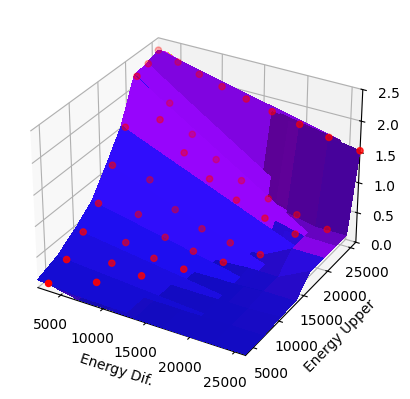

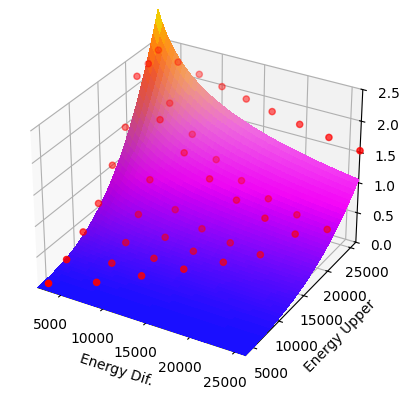

In [147]:
from matplotlib.colors import LightSource
from scipy.interpolate import griddata
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# epsilon = 1 / (ac.h * ac.c.cgs * (2000 / u.cm) / (ac.k_B * 300 * u.K))
# print(epsilon * np.exp(-epsilon))

"""
C(j<-i) = b(T?) * exp(-a(E_j - E_i)/k_B*T)
"""
quenching_total = [0.013, 0.0265, 0.052, 0.088, 0.17, 0.3, 0.7, 0.8, 1.7]  # + [1.5, 2.79, 1.6] (*1e-11)
quenching_unc = [0.004, 0.0096519428, 0.015, 0.03, 0.07, 0.15, 0.2, 0.1, 1.1]  # + [0.12, 0.14, 0.2] (*1e-11)
p_v_list = [0.043, 0.083, 0.15, 0.23, 0.36, 0.50, 0.72, 0.75, 0.95]  # + [0.8, 0.97, ???] (fit, not necessarily accurate!)

# fit_extra = [3.21515904, 3.83866479, 4.39559635, 4.82923495, 5.08618411, 5.79519431, 5.92829026, 6.22476161, 6.2462764,
#              6.59709307, 7.0635486, 7.63462636, 7.79270072, 8.60716109]
# quenching_total += fit_extra
# p_v_list += [1.0 for _ in range(len(fit_extra))]

# print(quenching_total)
# print(p_v_list)
temperature = 300
c_const = 3.1812  #e-12
c_const_list = [3.023255813953489, 2.948080410283794, 2.9566453447050467, 2.9543544515625357,
                3.040607613734122, 3.0476190476190474, 3.0257205402010414, 2.9633347463614528, 2.419838847150622]

mass_oh = 15.99491461957 + 1.00782503223
mass_o2 = 15.99491461957 * 2
reduced_mass = ((mass_oh * mass_o2) / (mass_oh + mass_o2) * u.Da).to(u.kg)
rate_constant = (np.pi * np.sqrt(8 * ac.k_B * temperature * u.K / (np.pi * reduced_mass))).to(u.cm / u.s)


# print(reduced_mass)
# print(rate_constant)


def get_v_rates(v_val: int):
    # print(f"v={v_val}", 10*quenching_total[v_val - 1]/sum([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)]))
    # print(f"v={v_val}", sum(c_const_list[v_val - 1] * np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])))
    return c_const_list[v_val - 1] * np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])


def calc_rate(inputs, energy_upper, energy_dif) -> float:
    # return rate_constant.value * inputs[0] * (energy_upper**inputs[3]) * (energy_dif**inputs[2]) * np.exp(
    #     -inputs[1] * ac.h.value * ac.c.cgs.value * energy_dif / (ac.k_B.value * temperature)
    # ) + inputs[4]
    return inputs[0] * ((inputs[1] * energy_upper)**inputs[2]) * np.exp(
        -inputs[3] * (ac.h.value * ac.c.cgs.value * energy_dif / (ac.k_B.value * temperature))**inputs[4]
    ) + inputs[5]


def fit_rates(inputs):
    v_list = np.arange(1, len(quenching_total) + 1)
    cost = []
    for v_val in v_list:
        rates = get_v_rates(v_val)
        # print(f"v'={v_val}, rates = {rates}. P_v = {p_v_list[v_val - 1]}, Sum(k)={sum(rates)}")
        energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
        for idx, delta_v in enumerate(np.arange(1, v_val + 1)):
            energy_lower = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - delta_v), "energy_agg"].values[0]
            energy_dif = energy_upper - energy_lower
            rate = calc_rate(inputs, energy_upper, energy_dif)
            # print(calc_rate, rates[idx])
            rate_unc = quenching_unc[v_val - 1] * rates[idx]/(quenching_total[v_val - 1] * 10)
            cost.append((rate - rates[idx])**2)
            # cost.append(((rate - rates[idx])/rate_unc)**2)

    return np.sqrt(np.mean(cost))


# x0 = [7.395e-24,  2.420e-03, -2.513e-01,  0, 4.338e+00]
x0 = [1.166e+00, 9.761e-05, 3.125e+00, 1.340e+00, 1.691e-01, 0.000e+00]
# bounds = [(-1, 1), (-1, 1), (-5, 5), (-10, 10)]
bounds = ([1e-5, 5], [1e-8, 1e-2], [1e-1, 5], [1e-5, 2], [1e-5, 1], [0, 1e-8])
# bounds = (-50, 100)
# print(bounds)

minimize_tol = 1e-15
res = minimize(fit_rates, x0,
               bounds=bounds,
               # tol=1e-10,
               method="L-BFGS-B",
               options={
                    "ftol": minimize_tol,
                    "gtol": minimize_tol,
                    "maxfun": 10000,
                    "maxiter": 10000,
               },
               )
# res = least_squares(fit_rates, x0, bounds=bounds, method="trf", ftol=1e-15, gtol=1e-15, xtol=1e-15,)
print(res)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, RationalQuadratic

x_data = []
x_unc = []
y_data = []
for v_val in range(1, len(quenching_total) + 1):
    test_rates = get_v_rates(v_val)
    energy_upper = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
    ].values[0]
    v_energy_difs = []
    for idx, delta_v in enumerate(np.arange(1, v_val + 1)):
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - delta_v), "energy_agg"
        ].values[0]
        energy_dif = energy_upper - energy_lower
        x_data.append([energy_dif, energy_upper])
        y_data.append([test_rates[idx]])
        x_unc.append(quenching_unc[v_val - 1] * test_rates[idx]/(quenching_total[v_val - 1] * 10))
x_train = np.array(x_data)
x_unc = np.array(x_unc)
y_train = np.array(y_data)
# print(x_train, y_train)

kernel = ConstantKernel(1.0) * RBF(length_scale=[1.5, 1])  # Adjust length scale based on data
# kernel = RBF(length_scale=1.0) + RationalQuadratic(length_scale=1.0, alpha=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=x_unc**2)
gpr.fit(x_train, y_train)

# poly = PolynomialFeatures(degree=3)
# x_poly = poly.fit_transform(x_train)
# model = LinearRegression()
# model.fit(x_poly, y_train)

x_test_data = []
for pred_v_val in [8, 9, 10, 11]:
    energy_upper = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == pred_v_val), "energy_agg"
    ].values[0]
    energy_lower = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] < pred_v_val), "energy_agg"
    ].to_numpy()
    # print("Lower energies: ", energy_lower)
    energy_difs = energy_upper - energy_lower
    x_test = np.zeros((len(energy_difs), 2))
    x_test[:, 0] = energy_difs
    x_test[:, 1] = energy_upper
    # print("X test: ", x_test)
    x_test_data.append(x_test)
x_test = np.concatenate(x_test_data)
y_pred, sigma = gpr.predict(x_test, return_std=True)
# x_test_poly = poly.transform(x_test)
# y_pred = model.predict(x_test_poly)
# print(y_pred)

residuals = []
v_colors = get_vibrant_colors(n_colors=len(quenching_total))
mesh_coords = []
z_coords = []
for v_val in range(1, len(quenching_total) + 1):
    v_color = v_colors[v_val - 1]
    test_rates = get_v_rates(v_val)
    energy_upper = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
    ].values[0]
    energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] < v_val), "energy_agg"
    ].to_numpy()[::-1]
    energy_difs = energy_upper - energy_lower
    rates = calc_rate(res.x, energy_upper, energy_difs)
    residuals.append(test_rates - rates)
    test_rate_unc = quenching_unc[v_val - 1] * test_rates/(quenching_total[v_val - 1] * 10)
    plt.errorbar(energy_difs, test_rates, yerr=test_rate_unc, color=v_color, label=f"v={v_val}", marker="D", linestyle="--")

    coords_xyz = np.zeros((len(energy_difs), 3))
    coords_xyz[:, 0] = energy_difs
    coords_xyz[:, 1] = energy_upper
    coords_xyz[:, 2] = test_rates
    mesh_coords.append(coords_xyz)
    # z_coords.append(test_rates)
residuals = np.concatenate(residuals)
print(f"Fit RMS = {np.sqrt(np.mean(np.array(residuals)**2))}")
# plt.scatter(x_test[:, 0], y_pred, color="#FF0000", zorder=10)
plt.legend(loc="best")
plt.show()

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax = plt.axes(projection='3d', computed_zorder=False)
mesh_coords = np.concatenate(mesh_coords)
meshgrid_x, meshgrid_y = np.meshgrid(mesh_coords[:, 0], mesh_coords[:, 1])
# z_coords = np.concatenate(z_coords)
meshgrid_z = griddata((mesh_coords[:, 0], mesh_coords[:, 1]), mesh_coords[:, 2], (meshgrid_x, meshgrid_y), method='nearest')

ls = LightSource(270, 45)
rgb = ls.shade(meshgrid_z, cmap=cm.plasma, vert_exag=2.0, blend_mode='soft')

surf = ax.plot_surface(meshgrid_x, meshgrid_y, meshgrid_z, rstride=1, cstride=1,
                       facecolors=ls.shade(meshgrid_z, cmap=cm.plasma, vert_exag=2.0, blend_mode="overlay"),
                       # cmap=cm.plasma,
                       linewidth=0, antialiased=False, shade=False, zorder=1)
ax.scatter(mesh_coords[:, 0], mesh_coords[:, 1], mesh_coords[:, 2], color="#FF0000", zorder=2)
plt.xlabel("Energy Dif.")
plt.ylabel("Energy Upper")
plt.xlim(meshgrid_x.min(), meshgrid_x.max())
plt.ylim(meshgrid_y.min(), meshgrid_y.max())
ax.set_zlim(bottom=0, top=2.5)
plt.show()

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax = plt.axes(projection='3d', computed_zorder=False)
fit_x = np.linspace(meshgrid_x.min(), meshgrid_x.max(), 50)
fit_y = np.linspace(meshgrid_y.min(), meshgrid_y.max(), 50)
fitgrid_x, fitgrid_y = np.meshgrid(fit_x, fit_y)
fitgrid_z = calc_rate(res.x, fitgrid_y, fitgrid_x)
fit_surface = ax.plot_surface(fitgrid_x, fitgrid_y, fitgrid_z, rstride=1, cstride=1,
                              facecolors=ls.shade(fitgrid_z, cmap=cm.plasma, vert_exag=2.0, blend_mode="overlay"),
                              # cmap=cm.plasma,
                              linewidth=0, antialiased=False, shade=False, zorder=1)

ax.scatter(mesh_coords[:, 0], mesh_coords[:, 1], mesh_coords[:, 2], color="#FF0000", zorder=2)
plt.xlabel("Energy Dif.")
plt.ylabel("Energy Upper")
plt.xlim(fit_x[0], fit_x[-1])
plt.ylim(fit_y[0], fit_y[-1])
ax.set_zlim(bottom=0, top=2.5)
plt.show()
# print(f"C const. = {res.x[0]} (initial = {x0[0]})")
# print(f"P_v values = {res.x[1:]} (initial = {p_v_list[9:]})")

# Helium quenching

In [9]:
a_const = -21.6
b_const = 0.00459
for v_val in range(1, 13):
    energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
    energy_lower = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
    energy_dif = energy_upper - energy_lower
    rate = v_val * np.exp(a_const - b_const * energy_dif)
    # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
    print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "He")  # @ 298 K')

add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 3.2e-17, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 1.4e-16, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 3, "X2Pi", 2, 4.4e-16, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 4, "X2Pi", 3, 1.2e-15, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 5, "X2Pi", 4, 3.2e-15, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 6, "X2Pi", 5, 8.2e-15, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 7, "X2Pi", 6, 2.1e-14, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 8, "X2Pi", 7, 5.1e-14, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 9, "X2Pi", 8, 1.3e-13, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 10, "X2Pi", 9, 3.4e-13, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 11, "X2Pi", 10, 9.5e-13, "He")  # @ 298 K
add_col_chem_rate("X2Pi", 12, "X2Pi", 11, 2.9e-12, "He")  # @ 298 K


# Hydrogen Quenching

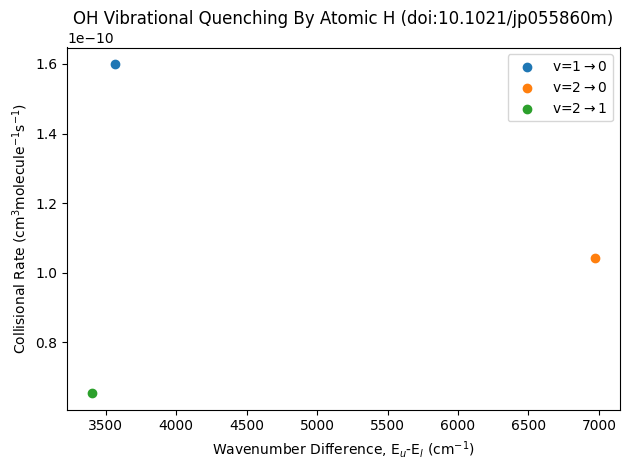

In [56]:
# add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 1.600e-10, "H")  # @ 300 K
# add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 0.654e-10, "H")  # @ 300 K
# add_col_chem_rate("X2Pi", 2, "X2Pi", 0, 1.043e-10, "H")  # @ 300 K

h_rates = np.zeros((3, 3))
h_rates[1, 0] = 1.600e-10
h_rates[2, 1] = 0.654e-10
h_rates[2, 0] = 1.043e-10

for v_val in range(1, 3):
    energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
    for lower_v in range(0, v_val):
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == lower_v), "energy_agg"].values[0]
        energy_dif = energy_upper - energy_lower
        rate = h_rates[v_val, lower_v]
        plt.scatter(energy_dif, rate, label=fr"v={v_val}$\rightarrow${lower_v}")
plt.legend(loc="best")
plt.ylabel("Collisional Rate (cm$^{3}$molecule$^{-1}$s$^{-1}$)")
plt.xlabel("Wavenumber Difference, E$_{u}$-E$_{l}$ (cm$^{-1}$)")
plt.title("OH Vibrational Quenching By Atomic H (doi:10.1021/jp055860m)")
plt.tight_layout()
plt.show()

In [7]:
a_const = -21.6
b_const = 0.00459
for v_val in range(1, 3):
    energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
    if v_val == 2:
        # v'' = 1
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
        energy_dif = energy_upper - energy_lower
        rate = v_val * np.exp(a_const - b_const * energy_dif)
        # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
        print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
        #v'' = 0
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 2), "energy_agg"].values[0]
        energy_dif = energy_upper - energy_lower
        rate = v_val * np.exp(a_const - b_const * energy_dif)
        # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
        print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 2}, {rate:.1e}, "H")  # @ 298 K')
    else:
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
        energy_dif = energy_upper - energy_lower
        rate = v_val * np.exp(a_const - b_const * energy_dif)
        print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')


def calc_rate(energy_dif, a_const, b_const, c_const):
    return np.exp(a_const - b_const * energy_dif)  # * (energy_dif**c_const)

def fit_rates(inputs):
    print(inputs)
    a_const = inputs[0]
    b_const = inputs[1]
    c_const = inputs[2]
    # d_const = inputs[3]
    rates = []
    for v_val in range(1, 3):
        energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
        if v_val == 4:
            # v'' = 1
            energy_lower = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
            energy_dif = energy_upper - energy_lower
            rate = calc_rate(energy_dif, a_const, b_const, c_const)
            rates.append(rate)
            # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
            print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
            #v'' = 0
            energy_lower = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 2), "energy_agg"].values[0]
            energy_dif = energy_upper - energy_lower
            rate = calc_rate(energy_dif, a_const, b_const, c_const)
            rates.append(rate)
            # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
            print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 2}, {rate:.1e}, "H")  # @ 298 K')
        else:
            energy_lower = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
            energy_dif = energy_upper - energy_lower
            rate = calc_rate(energy_dif, a_const, b_const, c_const)
            rates.append(rate)
            print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
    rates = np.array(rates)
    print(rates_target, rates)
    # error = (rates_target - rates) ** 2
    # error = sum(np.log10(error))
    # print(error)
    error = sum(1e18 * (rates_target - rates) ** 2)
    return error

# rate_dict = {
#     (1, 0): 1.600e-10,
#     (2, 1): 0.654e-10,
#     (2, 0): 1.043e-10,
# }
# rates_target = np.array([1.600e-10, 0.654e-10, 1.043e-10])
rates_target = np.array([1.600e-10, 0.654e-10 + 1.043e-10])

# x0 = [-21.6, 0.00459]
# x0 = [-2.14608426e+01,  7.88403335e-04]
# x0 = [-2.16e+01, 0.00459,
#       1e-3,
#       # 1
#       ]
x0 = [-2.15999987e+01, 2.68092691e-04,
      1.01018362e-03,
      # 1.00000127e+00
      ]
bounds = [(-1e2, 0), (1e-6, 1e-2),
          (1e-6, 1e-2),
          # (1e-2, 1e1)
          ]
print(bounds)

minimize_tol = 1e-15
res = minimize(fit_rates, x0,
               bounds=bounds,
               # tol=1e-10,
               method="L-BFGS-B",
               options={
                    "ftol": minimize_tol,
                    "gtol": minimize_tol,
                    "maxfun": 10000,
                    "maxiter": 10000,
               },
               )
print(res)

for v_val in range(1, 12):
    energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
    energy_lower = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
    energy_dif = energy_upper - energy_lower
    rate = calc_rate(energy_dif, res.x[0], res.x[1], res.x[2])
    print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 300 K single-quantum extrapolation')

add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 3.2e-17, "H")  # @ 298 K
add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 1.4e-16, "H")  # @ 298 K
add_col_chem_rate("X2Pi", 2, "X2Pi", 0, 1.1e-23, "H")  # @ 298 K
[(-100.0, 0), (1e-06, 0.01), (1e-06, 0.01)]
[-2.15999987e+01  2.68092691e-04  1.01018362e-03]
add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 1.6e-10, "H")  # @ 298 K
add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 1.7e-10, "H")  # @ 298 K
[1.600e-10 1.697e-10] [1.59866857e-10 1.67124103e-10]
[-2.15999987e+01  2.68092691e-04  1.01018362e-03]
add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 1.6e-10, "H")  # @ 298 K
add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 1.7e-10, "H")  # @ 298 K
[1.600e-10 1.697e-10] [1.59866859e-10 1.67124105e-10]
[-2.15999987e+01  2.68102691e-04  1.01018362e-03]
add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 1.6e-10, "H")  # @ 298 K
add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 1.7e-10, "H")  # @ 298 K
[1.600e-10 1.697e-10] [1.59861152e-10 1.67118416e-10]
[-2.15999987e+01  2.68092691e-04  1.01019362e-03]
add_col_c

In [53]:
quenching_total = [1.600, 0.654e-10 + 1.043e-10,] #  0.052, 0.088, 0.17, 0.3, 0.7, 0.8, 1.7, 1.5, 2.79]  # e-10
print(quenching_total)
p_v_list = [0.043, 0.083,]  # 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
print(p_v_list)


def fit_rates(inputs):
    c_const = inputs[0]
    fit_p_v_list = inputs[1:]
    v_list = np.arange(1, len(quenching_total) + 1)
    error = 0
    for v_val in v_list:
        if v_val <= 0:
            rates = c_const * np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])
            print(f"v'={v_val}, rates = {rates}. P_v = {p_v_list[v_val - 1]}, Sum(k)={sum(rates)}")
        else:
            rates = c_const * np.array([fit_p_v_list[v_val - (fit_from_idx + 1)] ** delta_v for delta_v in np.arange(1, v_val + 1)])
            # print(f"v'={v_val}, rates = {rates}. P_v = {fit_p_v_list[v_val - 10]}, Sum(k)={sum(rates)}")
        error += (sum(rates) - quenching_total[v_val - 1]) ** 2
    return error

fit_from_idx = 0
x0 = [0.31812] + p_v_list[fit_from_idx:]
bounds = [(1e-3, 1e3), ] + [(0.5, 1.5) for _ in range(len(p_v_list[fit_from_idx:]))]
print(bounds)

minimize_tol = 1e-15
res = minimize(fit_rates, x0,
               bounds=bounds,
               # tol=1e-10,
               method="L-BFGS-B",
               options={
                    "ftol": minimize_tol,
                    "gtol": minimize_tol,
                    "maxfun": 10000,
                    "maxiter": 10000,
               },
               )
print(res)


def test_rates(v_val, c_const, p_v_list):
    p_v_delta_v_list = np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])
    return c_const * p_v_delta_v_list


new_p_v_list = np.concatenate((p_v_list[:fit_from_idx], res.x[1:]))

for v_val in range(1, len(quenching_total) + 1):
    test_rate = test_rates(v_val, res.x[0], new_p_v_list)
    print(f"v'={v_val}, Sum(k(v'')) = {sum(test_rate)}. Target Sum(k(v'')) = {quenching_total[v_val - 1]}")

print(f"C const. = {res.x[0]} (initial = {x0[0]})")
print(f"P_v values = {res.x[1:]} (initial = {p_v_list[fit_from_idx:]})")

[1.6, 1.697e-10]
[0.043, 0.083]
[(0.001, 1000.0), (0.5, 1.5), (0.5, 1.5)]
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.5119999997827841
        x: [ 8.533e-01  1.500e+00  5.000e-01]
      nit: 5
      jac: [ 0.000e+00 -5.461e-01  2.185e+00]
     nfev: 32
     njev: 8
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
v'=1, Sum(k(v'')) = 1.2799999910793853. Target Sum(k(v'')) = 1.6
v'=2, Sum(k(v'')) = 0.6399999955396927. Target Sum(k(v'')) = 1.697e-10
C const. = 0.8533333273862569 (initial = 0.31812)
P_v values = [1.5 0.5] (initial = [0.043, 0.083])


# H2 Rates

add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 1.0e-14, "H2")  # @ 300 K single-quantum extrapolation
add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 4.0e-14, "H2")  # @ 300 K single-quantum extrapolation
add_col_chem_rate("X2Pi", 3, "X2Pi", 2, 9.0e-14, "H2")  # @ 300 K single-quantum extrapolation
add_col_chem_rate("X2Pi", 4, "X2Pi", 3, 1.8e-13, "H2")  # @ 300 K single-quantum extrapolation
add_col_chem_rate("X2Pi", 5, "X2Pi", 4, 3.9e-13, "H2")  # @ 300 K single-quantum extrapolation
add_col_chem_rate("X2Pi", 6, "X2Pi", 5, 6.8e-13, "H2")  # @ 300 K single-quantum extrapolation
add_col_chem_rate("X2Pi", 7, "X2Pi", 6, 8.0e-13, "H2")  # @ 300 K single-quantum extrapolation
add_col_chem_rate("X2Pi", 8, "X2Pi", 7, 7.6e-13, "H2")  # @ 300 K single-quantum extrapolation
add_col_chem_rate("X2Pi", 9, "X2Pi", 8, 5.8e-13, "H2")  # @ 300 K single-quantum extrapolation
add_col_chem_rate("X2Pi", 10, "X2Pi", 9, 4.4e-13, "H2")  # @ 300 K single-quantum extrapolation


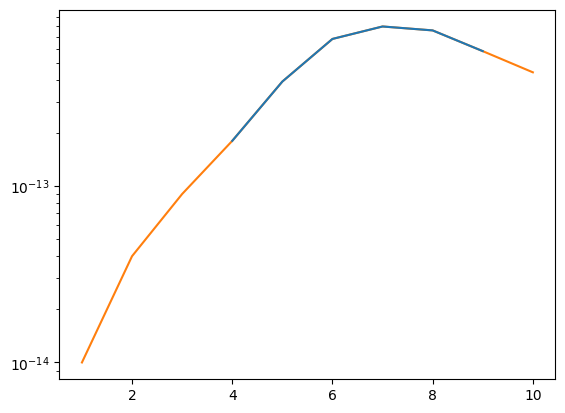

In [38]:
v_u_list = np.arange(4, 10)
h2_rates = np.array([1.8, 3.9, 6.8, 8.0, 7.6, 5.8]) * 1e-13

v_full = np.arange(1, 11)
h2_rates_full = np.concatenate(([1.0e-14, 4.0e-14, 9.0e-14], h2_rates, [4.4e-13]))

# fit_low = np.polyfit(np.arange(4, 7), h2_rates[:3], 1)
# # print(fit)
# fit_v_low = np.arange(1, 7)
# fit_low_func = np.poly1d(fit_low)
# # fit_rate_list = [sum(fit_coef * fit_v**(1-idx) for idx, fit_coef in enumerate(fit)) for fit_v in fit_v_list ]
# # print(fit_rate_list)

for v_val in v_full:
    print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {h2_rates_full[v_val - 1]:.1e}, "H2")  # @ 300 K single-quantum extrapolation')

plt.plot(v_u_list, h2_rates, zorder=2)
plt.plot(v_full, h2_rates_full, zorder=1)
plt.yscale("log")
plt.show()

# Other?

In [17]:
layer_old_pops = np.array([1.72847674e-003, 1.47947966e-002, 2.70026691e-002, 3.71271571e-002, 4.47593226e-002, 4.92583645e-002, 4.97541405e-002, 5.21087831e-002, 4.86160168e-002, 5.12313993e-002, 5.04622520e-002, 5.16229894e-002, 4.55753474e-002, 5.30468960e-041, 4.29672113e-002, 3.43695124e-002, 3.16920164e-002, 1.51744526e-040, 3.31577489e-002, 3.47553376e-002, 3.96349808e-002, 3.52991833e-002, 3.76890802e-002, 3.57842037e-002, 7.11767011e-034, 3.52444730e-002, 3.93386389e-002, 4.05567790e-002, 3.54091388e-002, 8.06587558e-033, 2.18581194e-032, 1.65096449e-031, 2.94814477e-030, 1.05546581e-075, 2.90142126e-006, 5.33461831e-006, 2.90717889e-006, 3.57914496e-006, 5.02250264e-006, 2.81950572e-006, 1.77203162e-006, 4.70387828e-006, 1.23400701e-005, 3.66789873e-006, 7.99464947e-006, 9.09761432e-007, 2.39582740e-006, 1.48044264e-006, 2.14531337e-006, 4.94065646e-324, 4.92737337e-019, 3.29493320e-009])

layer_new_pops = np.array([4.24346369e-002, 4.51816054e-002, 4.74085519e-002, 4.89307802e-002, 4.89790640e-002, 4.86203650e-002, 4.71599356e-002, 4.87645449e-002, 4.59054834e-002, 4.62069497e-002, 4.31269000e-002, 4.31568017e-002, 3.81640846e-002, 4.94065646e-324, 3.63903397e-002, 2.85840203e-002, 2.63611795e-002, 4.94065646e-324, 2.80816102e-002, 2.99403653e-002, 3.43503978e-002, 3.01462940e-002, 3.25092586e-002, 3.08164623e-002, 4.94065646e-324, 3.02257145e-002, 3.34095164e-002, 3.47050439e-002, 3.03130219e-002, 4.94065646e-324, 4.94065646e-324, 4.94065646e-324, 6.97835682e-007, 3.39869363e-006, 7.23355423e-006, 7.69781481e-006, 4.28558611e-006, 5.44202591e-006, 8.08451491e-006, 5.95151921e-006, 5.98053416e-006, 6.45980516e-006, 1.97749857e-005, 9.15944448e-006, 1.33965071e-005, 6.45327865e-006, 5.60836868e-006, 8.25791840e-006, 9.17869451e-006, 8.41075216e-106, 1.22703949e-046, 1.11520391e-008])

layer_delta_pops = layer_new_pops - layer_old_pops
np.abs(layer_delta_pops / layer_old_pops).max()

np.float64(1.7023551891933299e+218)

# Final rates

In [13]:
a_const = -21.6
b_const = 0.00459
for v_val in range(1, 3):
    energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
    if v_val == 2:
        # v'' = 1
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
        energy_dif = energy_upper - energy_lower
        rate = v_val * np.exp(a_const - b_const * energy_dif)
        # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
        print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
        #v'' = 0
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 2), "energy_agg"].values[0]
        energy_dif = energy_upper - energy_lower
        rate = v_val * np.exp(a_const - b_const * energy_dif)
        # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
        print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 2}, {rate:.1e}, "H")  # @ 298 K')
    else:
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
        energy_dif = energy_upper - energy_lower
        rate = v_val * np.exp(a_const - b_const * energy_dif)
        print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')


def calc_rate(energy_dif, a_const, b_const):
    return np.exp(a_const - b_const * energy_dif)  # * (energy_dif**c_const)

def fit_rates(inputs):
    print(inputs)
    a_const = inputs[0]
    b_const = inputs[1]
    # c_const = inputs[2]
    # d_const = inputs[3]
    rates = []
    for v_val in range(1, 11):
        energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
        if v_val == 1000:  # 4
            # v'' = 1
            energy_lower = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
            energy_dif = energy_upper - energy_lower
            rate = calc_rate(energy_dif, a_const, b_const) # , c_const)
            rates.append(rate)
            # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
            print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
            #v'' = 0
            energy_lower = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 2), "energy_agg"].values[0]
            energy_dif = energy_upper - energy_lower
            rate = calc_rate(energy_dif, a_const, b_const) # , c_const)
            rates.append(rate)
            # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
            print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 2}, {rate:.1e}, "H")  # @ 298 K')
        else:
            print("here")
            energy_lower = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
            energy_dif = energy_upper - energy_lower
            rate = calc_rate(energy_dif, a_const, b_const) # , c_const)
            rates.append(rate)
            print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
    rates = np.array(rates)
    print(rates_target, rates)
    # error = (rates_target - rates) ** 2
    # error = sum(np.log10(error))
    # print(error)
    error = sum(1e18 * (rates_target - rates) ** 2)
    return error

# rate_dict = {
#     (1, 0): 1.600e-10,
#     (2, 1): 0.654e-10,
#     (2, 0): 1.043e-10,
# }
# rates_target = np.array([1.600e-10, 0.654e-10, 1.043e-10])
rates_target = np.array([1.600e-10, 0.654e-10 + 1.043e-10, 1.8e-10, 1.8e-10, 1.9e-10, 2.0e-10, 2.1e-10, 2.2e-10, 2.3e-10, 2.4e-10])

# x0 = [-21.6, 0.00459]
# x0 = [-2.14608426e+01,  7.88403335e-04]
# x0 = [-2.16e+01, 0.00459,
#       1e-3,
#       # 1
#       ]
x0 = [-2.15999987e+01, 2.68092691e-04,
      # 1.01018362e-03,
      # 1.00000127e+00
      ]
bounds = [(-1e2, 0), (1e-6, 1e-2),
          # (1e-6, 1e-2),
          # (1e-2, 1e1)
          ]
print(bounds)

minimize_tol = 1e-15
res = minimize(fit_rates, x0,
               bounds=bounds,
               # tol=1e-10,
               method="L-BFGS-B",
               options={
                    "ftol": minimize_tol,
                    "gtol": minimize_tol,
                    "maxfun": 10000,
                    "maxiter": 10000,
               },
               )
print(res)

for v_val in range(1, 12):
    energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
    energy_lower = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
    energy_dif = energy_upper - energy_lower
    rate = calc_rate(energy_dif, res.x[0], res.x[1]) # , res.x[2])
    print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 300 K single-quantum extrapolation')
print(f"Params: a={res.x[0]}, b={res.x[1]}")

add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 3.2e-17, "H")  # @ 298 K
add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 1.4e-16, "H")  # @ 298 K
add_col_chem_rate("X2Pi", 2, "X2Pi", 0, 1.1e-23, "H")  # @ 298 K
[(-100.0, 0), (1e-06, 0.01)]
[-2.15999987e+01  2.68092691e-04]
here
add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 1.6e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 1.7e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 3, "X2Pi", 2, 1.7e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 4, "X2Pi", 3, 1.8e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 5, "X2Pi", 4, 1.9e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 6, "X2Pi", 5, 2.0e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 7, "X2Pi", 6, 2.1e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 8, "X2Pi", 7, 2.2e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 9, "X2Pi", 8, 2.3e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 10, "X2Pi", 9, 2.4e-10, "H")  # @ 298 K
[1.600e-10 1.697e-10 1.800e-10 1.800e-10 

In [15]:
a_const = -21.6
b_const = 0.00459
for v_val in range(1, 3):
    energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
    if v_val == 2:
        # v'' = 1
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
        energy_dif = energy_upper - energy_lower
        rate = v_val * np.exp(a_const - b_const * energy_dif)
        # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
        print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
        #v'' = 0
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 2), "energy_agg"].values[0]
        energy_dif = energy_upper - energy_lower
        rate = v_val * np.exp(a_const - b_const * energy_dif)
        # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
        print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 2}, {rate:.1e}, "H")  # @ 298 K')
    else:
        energy_lower = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
        energy_dif = energy_upper - energy_lower
        rate = v_val * np.exp(a_const - b_const * energy_dif)
        print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')


def calc_rate(energy_dif, a_const, b_const):
    return np.exp(a_const - b_const * energy_dif)  # * (energy_dif**c_const)

def fit_rates(inputs):
    print(inputs)
    a_const = inputs[0]
    b_const = inputs[1]
    # c_const = inputs[2]
    # d_const = inputs[3]
    rates = []
    for v_val in range(1, 11):
        energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
        if v_val == 1000:  # 4
            # v'' = 1
            energy_lower = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
            energy_dif = energy_upper - energy_lower
            rate = calc_rate(energy_dif, a_const, b_const) # , c_const)
            rates.append(rate)
            # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
            print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
            #v'' = 0
            energy_lower = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 2), "energy_agg"].values[0]
            energy_dif = energy_upper - energy_lower
            rate = calc_rate(energy_dif, a_const, b_const) # , c_const)
            rates.append(rate)
            # print(f"He rate (v={v_val}-{v_val - 1}) = {rate}")
            print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 2}, {rate:.1e}, "H")  # @ 298 K')
        else:
            energy_lower = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
            energy_dif = energy_upper - energy_lower
            rate = calc_rate(energy_dif, a_const, b_const) # , c_const)
            rates.append(rate)
            print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
    rates = np.array(rates)
    print(rates_target, rates)
    # error = (rates_target - rates) ** 2
    # error = sum(np.log10(error))
    # print(error)
    error = sum(1e18 * (rates_target - rates) ** 2)
    return error

# rate_dict = {
#     (1, 0): 1.600e-10,
#     (2, 1): 0.654e-10,
#     (2, 0): 1.043e-10,
# }
# rates_target = np.array([1.600e-10, 0.654e-10, 1.043e-10])
rates_target = np.array([1.600e-10, 0.654e-10 + 1.043e-10, 5.8e-10, 1.5e-09, 4.0e-09, 9.8e-09, 2.4e-08, 7.6e-08, 1.8e-07, 5.1e-07])

# x0 = [-21.6, 0.00459]
# x0 = [-2.14608426e+01,  7.88403335e-04]
# x0 = [-2.16e+01, 0.00459,
#       1e-3,
#       # 1
#       ]
x0 = [-2.15999987e+01, 2.68092691e-04,
      # 1.01018362e-03,
      # 1.00000127e+00
      ]
bounds = [(-1e2, 0), (1e-6, 1e-2),
          # (1e-6, 1e-2),
          # (1e-2, 1e1)
          ]
print(bounds)

minimize_tol = 1e-15
res = minimize(fit_rates, x0,
               bounds=bounds,
               # tol=1e-10,
               method="L-BFGS-B",
               options={
                    "ftol": minimize_tol,
                    "gtol": minimize_tol,
                    "maxfun": 10000,
                    "maxiter": 10000,
               },
               )
print(res)

for v_val in range(1, 11):
    energy_upper = agg_states.loc[
            (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
        ].values[0]
    energy_lower = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"].values[0]
    energy_dif = energy_upper - energy_lower
    rate = calc_rate(energy_dif, res.x[0], res.x[1]) # , res.x[2])
    print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 300 K single-quantum extrapolation')
print(f"Params: a={res.x[0]}, b={res.x[1]}")

add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 3.2e-17, "H")  # @ 298 K
add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 1.4e-16, "H")  # @ 298 K
add_col_chem_rate("X2Pi", 2, "X2Pi", 0, 1.1e-23, "H")  # @ 298 K
[(-100.0, 0), (1e-06, 0.01)]
[-2.15999987e+01  2.68092691e-04]
here
add_col_chem_rate("X2Pi", 1, "X2Pi", 0, 1.6e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 2, "X2Pi", 1, 1.7e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 3, "X2Pi", 2, 1.7e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 4, "X2Pi", 3, 1.8e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 5, "X2Pi", 4, 1.9e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 6, "X2Pi", 5, 2.0e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 7, "X2Pi", 6, 2.1e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 8, "X2Pi", 7, 2.2e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 9, "X2Pi", 8, 2.3e-10, "H")  # @ 298 K
here
add_col_chem_rate("X2Pi", 10, "X2Pi", 9, 2.4e-10, "H")  # @ 298 K
[1.600e-10 1.697e-10 5.800e-10 1.500e-09 

In [4]:
y_matrix = np.array([[-4.37302659e+03, 9.52595128e+03, 1.16283868e+03, 9.33813803e+01, 1.10741341e+01, 1.79927348e+00, 3.61106534e-01, 8.91254417e-02, 2.27418100e-02, 5.78047318e-03, 9.42791831e-04], [4.33616453e+03, -1.69924808e+04, 1.55979411e+04, 3.02664273e+03, 3.30848711e+02, 4.49514068e+01, 8.30584683e+00, 1.75986445e+00, 3.89488876e-01, 9.21851694e-02, 1.74784732e-02], [3.37556333e+01, 7.34755135e+03, -2.55275140e+04, 1.75883246e+04, 5.33388711e+03, 7.19997264e+02, 1.09937364e+02, 2.27203592e+01, 4.85178619e+00, 1.05457483e+00, 1.90601561e-01], [1.02348714e-01, 1.11338482e+02, 8.48918045e+03, -3.03512083e+04, 1.85861187e+04, 7.54278941e+03, 1.26139694e+03, 2.10201693e+02, 4.53614128e+01, 1.03771075e+01, 1.96629806e+00], [1.76127760e-03, 5.65738359e-01, 2.54803792e+02, 9.13155969e+03, -3.34385623e+04, 1.67483067e+04, 9.38279536e+03, 1.93864486e+03, 3.31821728e+02, 7.50732417e+01, 1.61609871e+01], [2.33006784e-04, 6.68051594e-03, 1.84376354e+00, 4.49799172e+02, 8.32443130e+03, -3.36313879e+04, 1.44081759e+04, 1.05386555e+04, 2.60098601e+03, 4.66230188e+02, 9.35498722e+01], [3.91376758e-05, 9.68338563e-04, 2.26618968e-02, 4.84933875e+00, 6.98333032e+02, 7.28816492e+03, -3.34807406e+04, 1.25079578e+04, 1.02980581e+04, 3.16189936e+03, 5.24704760e+02], [8.23100311e-06, 1.87111604e-04, 2.23262003e-03, 7.07014268e-02, 1.11968248e+01, 9.93749914e+02, 6.57845872e+03, -3.29086795e+04, 1.01012291e+04, 8.82309827e+03, 3.04006112e+03], [1.25486011e-06, 3.50177131e-05, 3.65300236e-04, 2.86618892e-03, 1.78613811e-01, 2.27859870e+01, 1.19793696e+03, 5.69198519e+03, -3.05424701e+04, 8.97621650e+03, 5.61743606e+03], [1.76618187e-07, 5.96387231e-06, 9.22656941e-05, 9.95119044e-04, 9.64138589e-03, 4.46550387e-01, 4.26704432e+01, 1.27862684e+03, 5.62286870e+03, -2.70125578e+04, 7.21851793e+03], [1.48072035e-08, 6.78377094e-07, 1.41453668e-05, 1.68337900e-04, 1.47934233e-03, 1.40783900e-02, 8.90957687e-01, 6.14874820e+01, 9.83144403e+02, 5.09351119e+03, -1.67874938e+04]])
energy = np.array([0.000000, 3568.471362, 6971.345730, 10210.544951, 13287.164225, 16201.306035, 18951.856806, 21536.198509, 23949.818606, 26185.788638, 28234.069756])
num_dens = 3.7928423406081024e+18 / u.cm**3
temp = 1467.0814741345837 * u.K

fixed_rates = [1.600e-10, 0.654e-10, 1.043e-10]
col_rates = [5.8e-10, 1.5e-09, 4.0e-09, 9.8e-09, 2.4e-08, 7.6e-08, 1.8e-07, 5.1e-07]

target_pops = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs_colr_test/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))[0, 20, :11]

def solve(fit_rates):
    fit_y = y_matrix.copy() << 1 / u.s
    #  1 -> 0:
    c_10 =  (fixed_rates[0] * u.cm**3 / u.s) * num_dens
    energy_u = energy[1]
    energy_l = energy[0]
    energy_dif = energy_u - energy_l
    c_01 = c_10 * np.exp(-(ac.h * energy_dif * u.k * ac.c) / (ac.k_B * temp))
    fit_y[1, 0] += c_01
    fit_y[0, 1] += c_10
    fit_y[1, 1] -= c_10
    fit_y[0, 0] -= c_01
    #  2 -> 1:
    c_21 =  (fixed_rates[1] * u.cm**3 / u.s) * num_dens
    energy_u = energy[2]
    energy_l = energy[1]
    energy_dif = energy_u - energy_l
    c_12 = c_21 * np.exp(-(ac.h * energy_dif * u.k * ac.c) / (ac.k_B * temp))
    fit_y[2, 1] += c_12
    fit_y[1, 2] += c_21
    fit_y[2, 2] -= c_21
    fit_y[1, 1] -= c_12
    #  2 -> 0:
    c_20 =  (fixed_rates[2] * u.cm**3 / u.s) * num_dens
    energy_u = energy[2]
    energy_l = energy[0]
    energy_dif = energy_u - energy_l
    c_02 = c_20 * np.exp(-(ac.h * energy_dif * u.k * ac.c) / (ac.k_B * temp))
    fit_y[2, 0] += c_02
    fit_y[0, 2] += c_20
    fit_y[2, 2] -= c_20
    fit_y[0, 0] -= c_02
    # Other
    for v_val in range(3, 11):
        c_vm =  (fit_rates[v_val - 3] * u.cm**3 / u.s) * num_dens
        energy_u = energy[v_val]
        energy_l = energy[v_val - 1]
        energy_dif = energy_u - energy_l
        c_mv = c_vm * np.exp(-(ac.h * energy_dif * u.k * ac.c) / (ac.k_B * temp))
        fit_y[v_val, v_val - 1] += c_mv
        fit_y[v_val - 1, v_val] += c_vm
        fit_y[v_val, v_val] -= c_vm
        fit_y[v_val - 1, v_val - 1] -= c_mv

    fit_y = fit_y.value
    fit_y /= abs(fit_y).sum(axis=1)[:, None]
    fit_y = np.vstack([fit_y, np.ones(fit_y.shape[1])])

    rhs = np.zeros(fit_y.shape[0])
    rhs[-1] = 1

    nppinv_pops = np.linalg.pinv(fit_y) @ rhs
    nppinv_pops /= nppinv_pops.sum()
    # print((target_pops - nppinv_pops)/target_pops)
    print(nppinv_pops)
    print(sum(abs(target_pops - nppinv_pops)))
    return sum(abs(target_pops - nppinv_pops)/target_pops)


minimize_tol = 1e-15
# res = least_squares(
#     solve, col_rates,
#     # bounds=(1e-11, 1e-5),
#     # tol=1e-10,
#     method="lm",
#     ftol=minimize_tol,
#     gtol=minimize_tol,
#     xtol=minimize_tol,
#     # "maxfun": 10000,
#     # "maxiter": 10000,
# )
bound = ((1e-10, 1e-5) for _ in col_rates)
res = minimize(
    solve, col_rates,
    bounds=bound,
    # tol=1e-10,
    method="L-BFGS-B",
    options={
        "ftol": minimize_tol,
        "fatol": minimize_tol,
        "xatol": minimize_tol,
        "gtol": minimize_tol,
        "xtol": minimize_tol,
        "maxfun": 1000,
        "maxiter": 1000,
    },
)
# res = basinhopping(solve, col_rates, niter=1000)
# from scipy.optimize import brute
# res = brute(solve, col_rates)
print(res)
print(solve(res.x))
print(target_pops)
# Start: 1.80
# Nelder-Mead (0.907) -> [8.049e-10, 2.877e-09, 1.001e-10, 7.712e-09, 3.428e-08, 4.118e-08, 2.356e-07, 1.475e-09]
# Powell (0.774) - > [7.326e-07, 4.030e-08, 1.004e-10, 2.360e-07, 1.634e-09, 4.383e-07, 2.633e-07, 2.940e-07]
# L-BFGS-B (0.646) -> [1.111e-10, 1.320e-10, 1.888e-10, 3.209e-10, 3.584e-07 4.163e-07, 5.432e-07, 7.933e-07]


/tmp/ipykernel_586756/890201655.py:83: OptimizeWarning: Unknown solver options: fatol, xatol, xtol
  res = minimize(


[9.69615876e-01 2.92970924e-02 1.04131968e-03 4.34535753e-05
 2.12706880e-06 1.22278005e-07 8.32304870e-09 6.94512000e-10
 7.58746375e-11 1.26538000e-11 2.22299523e-12]
0.0023860823298813847
[9.69615882e-01 2.92970926e-02 1.04131969e-03 4.34472533e-05
 2.12675928e-06 1.22260186e-07 8.32182514e-09 6.94405503e-10
 7.58616695e-11 1.26511671e-11 2.22230567e-12]
0.002386095227645287
[9.69615876e-01 2.92970924e-02 1.04131968e-03 4.34535753e-05
 2.12648921e-06 1.22244665e-07 8.32077029e-09 6.94318113e-10
 7.58522067e-11 1.26493983e-11 2.22208363e-12]
0.0023860835233355773
[9.69615876e-01 2.92970924e-02 1.04131968e-03 4.34535753e-05
 2.12706880e-06 1.22128250e-07 8.31290549e-09 6.93686108e-10
 7.57899958e-11 1.26419819e-11 2.22095779e-12]
0.002386082641723671
[9.69615876e-01 2.92970924e-02 1.04131968e-03 4.34535753e-05
 2.12706880e-06 1.22278005e-07 8.28030835e-09 6.91078604e-10
 7.55391056e-11 1.26107772e-11 2.21675109e-12]
0.0023860824200701595
[9.69615876e-01 2.92970924e-02 1.04131968e-03 4

In [14]:
solve(col_rates)

[9.69615876e-01 2.92970924e-02 1.04131968e-03 4.34535753e-05
 2.12706880e-06 1.22278005e-07 8.32304870e-09 6.94512000e-10
 7.58746375e-11 1.26538000e-11 2.22299523e-12]
0.0023860823298813847


np.float64(1.8018122942454868)